In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bert_score import score
from rouge_score import rouge_scorer

C:\Users\tomca\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing

In [2]:
original_articles = pd.read_csv('original_articles.csv', delimiter=';')
generated_articles = pd.read_csv('generated_articles.csv', delimiter=';')
llm_as_judge_scores = pd.read_csv('llm_as_judge_scores.csv')

Calculate bert, rouge1, rouge2, rougeL score for each article and save each value in dictionary for further use.

In [3]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
sections = ['Headline', 'Perex', 'Article']

# Dictionary for scores for each article
all_scores = {section: {'bert': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 'llm_as_judge': []} for section in sections}
# Calculate and save the scores
for section in sections:
    references = original_articles[section].dropna().tolist()
    hypotheses = generated_articles[section].dropna().tolist()

    # Compute BERTScore
    P, R, F1 = score(hypotheses, references, lang="en", rescale_with_baseline=False)
    all_scores[section]['bert'] = F1.tolist()

    # Compute ROUGE scores
    rouge_scores = [scorer.score(h, r) for h, r in zip(hypotheses, references)]
    all_scores[section]['rouge1'] = [r['rouge1'].fmeasure for r in rouge_scores]
    all_scores[section]['rouge2'] = [r['rouge2'].fmeasure for r in rouge_scores]
    all_scores[section]['rougeL'] = [r['rougeL'].fmeasure for r in rouge_scores]

all_scores['Article']['llm_as_judge'] = llm_as_judge_scores['LLM as judge score'].tolist()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Mean scores for sections

In [4]:
# Calculate mean scores
results = {
    'Section': [], 'Mean BERTScore': [], 'Mean ROUGE-1': [], 'Mean ROUGE-2': [], 'Mean ROUGE-L': [], 'Mean LLM as judge': [],
}
for section in sections:
    results['Section'].append(section)
    results['Mean BERTScore'].append(np.mean(all_scores[section]['bert']))
    results['Mean ROUGE-1'].append(np.mean(all_scores[section]['rouge1']))
    results['Mean ROUGE-2'].append(np.mean(all_scores[section]['rouge2']))
    results['Mean ROUGE-L'].append(np.mean(all_scores[section]['rougeL']))
    results['Mean LLM as judge'].append(np.mean(all_scores[section]['llm_as_judge']))


C:\Users\tomca\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tomca\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
results_df = pd.DataFrame(results)
results_df

,Section,Mean BERTScore,Mean ROUGE-1,Mean ROUGE-2,Mean ROUGE-L,Mean LLM as judge
0,Headline,0.819987,0.216052,0.078323,0.185340,NaN
1,Perex,0.821334,0.212362,0.067141,0.158299,NaN
2,Article,0.849916,0.412568,0.167888,0.211436,0.747083


# Calculate tag accuracy
This metric does not completely reflect the reality of correctly generated tags. For example, generated tags are missing spaces between words as well as diacritic. You can also see that sometimes it generates a synonym tags compared to the original or adds additional word into the tag. In these scenarios the tags have the same meaning, but will be evaluated as incorrect.

In [6]:
valid_rows = original_articles["Tags"].notna() & (original_articles["Tags"] != "N/A")

# Now, filter both references (original_articles) and hypotheses (generated_articles) based on valid rows
references = original_articles["Tags"][valid_rows]
hypotheses = generated_articles["Tags"][valid_rows]

correct_count = 0
total_count = 0

for ref, hyp in zip(references, hypotheses):
    # Transform references to lowercase and split by comma
    ref_tags = {tag.strip().lower() for tag in ref.split(',')}
    # Split hypotheses by space and convert to set
    hyp_tags = {tag.strip().lower() for tag in hyp.split()}

    print(f"ref: {ref_tags}\nhyp: {hyp_tags}")

    # For each tag in the hypothesis, check if it exists in the references
    for tag in hyp_tags:
        if tag in ref_tags:
            correct_count += 1
        total_count += 1

# Calculate the tag accuracy
tag_accuracy = correct_count / total_count if total_count > 0 else 0
print(f"\nTag accuracy metric: {tag_accuracy}")

ref: {'#štatistický úrad', '#stavebná produkcia', '#stavebníctvo', '#infraštruktúra'}
hyp: {'#slovenskéstavebníctvo', '#inžinierskestavby', '#stavebnáprodukcia', '#pokles'}
ref: {'#štatistický úrad', '#pohonné látky', '#benzín'}
hyp: {'#ekológicképalivá', '#nafta', '#benzín', '#cenypohonnychlatok'}
ref: {'#potraviny', '#ceny potravín'}
hyp: {'#cenovéhladiny', '#potraviny', '#eú', '#slovensko'}
ref: {'#potraviny', '#konsolidácia', '#ceny potravín', '#dph'}
hyp: {'#spotrebitelske_ceny', '#jadrova_inflacia', '#ekonomicka_stabilita', '#cista_inflacia'}
ref: {'#platy', '#inflácia'}
hyp: {'#statistiky', '#inflacia', '#priemerna_mesacna_mzda', '#hospodarstvo_sr'}
ref: {'#byty', '#výstavba', '#nájomné bývanie', '#výstavba bytov'}
hyp: {'#byty', '#vystavba', '#statistiky', '#pandemia'}
ref: {'#inflácia na slovensku', '#zdražovanie', '#ceny potravín'}
hyp: {'#mzdy', '#inflacia', '#slovensko', '#reazrobky'}
ref: {'#platy', '#inflácia'}
hyp: {'#ceny', '#spotrebitelskéceny', '#slovensko', '#infláci

# Plotting the score distribution of the different score types across section through histogram.

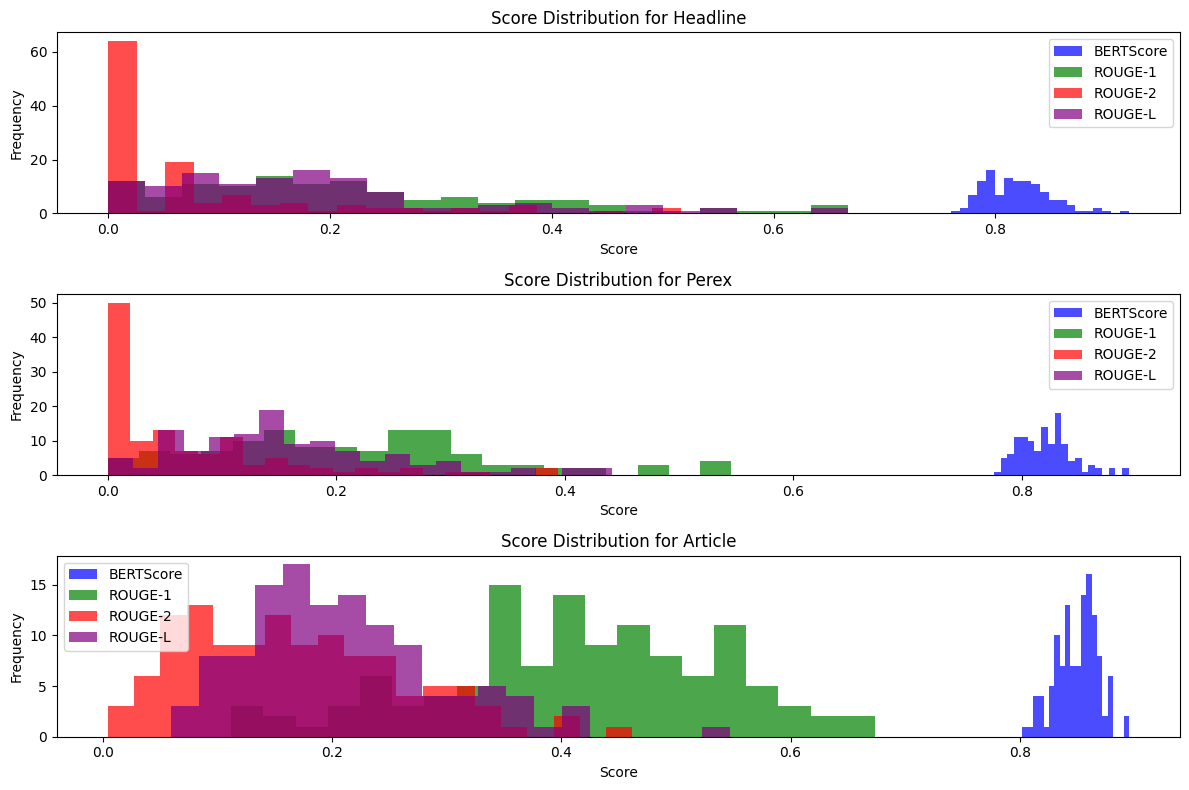

In [7]:
plt.figure(figsize=(12, 8))
for i, section in enumerate(sections):
    plt.subplot(3, 1, i+1)
    plt.hist(all_scores[section]['bert'], bins=20, alpha=0.7, label='BERTScore', color='blue')
    plt.hist(all_scores[section]['rouge1'], bins=20, alpha=0.7, label='ROUGE-1', color='green')
    plt.hist(all_scores[section]['rouge2'], bins=20, alpha=0.7, label='ROUGE-2', color='red')
    plt.hist(all_scores[section]['rougeL'], bins=20, alpha=0.7, label='ROUGE-L', color='purple')
    #plt.hist(all_scores[section]['llm_as_judge'], bins=20, alpha=0.7, label='LLM as judge', color='yellow')
    plt.title(f'Score Distribution for {section}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

# Boxplots of score types to showcase comparison of how well we did in different sections.

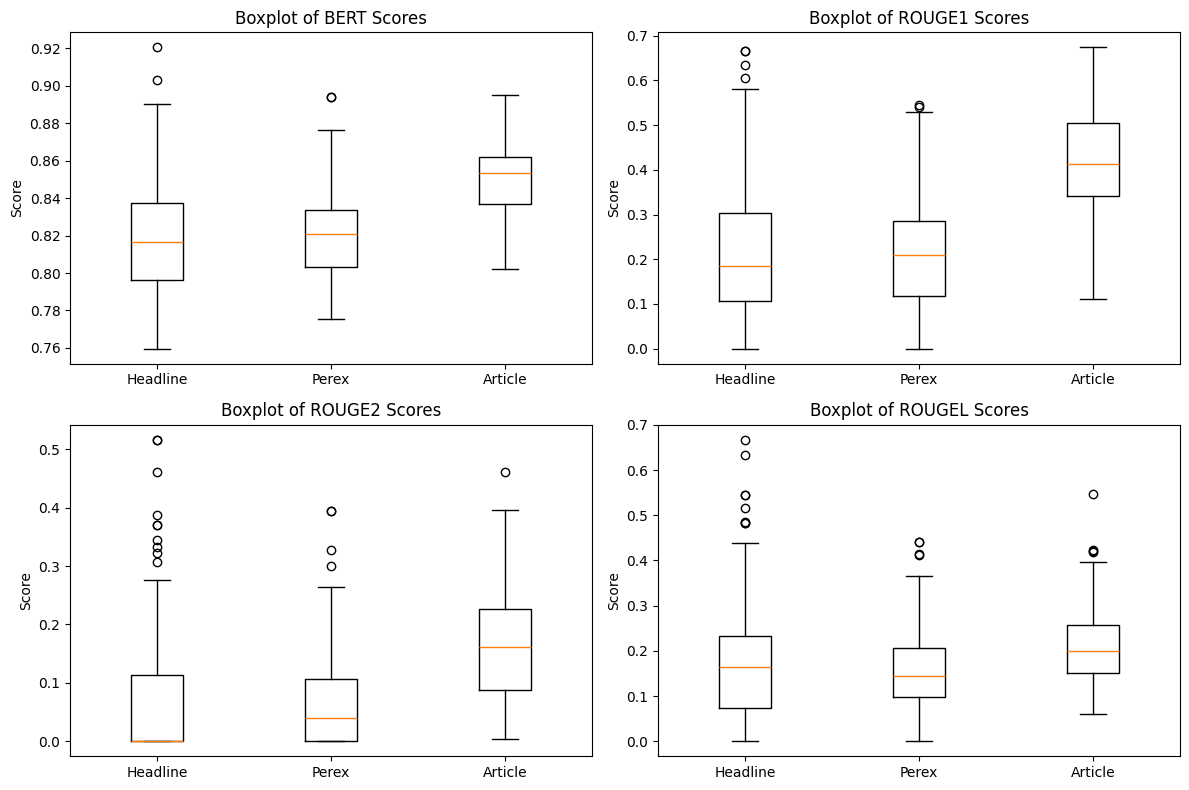

In [8]:
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['bert', 'rouge1', 'rouge2', 'rougeL']):
    plt.subplot(2, 2, i+1)
    plt.boxplot([all_scores[section][metric] for section in sections], tick_labels=sections)
    plt.title(f'Boxplot of {metric.upper()} Scores')
    plt.ylabel('Score')
plt.tight_layout()
plt.show()


# Aggregated scores for each news site

In [9]:
concat_articles = pd.concat([original_articles, generated_articles], ignore_index=True)
news_site_results = concat_articles.groupby('News Site').apply(lambda df: pd.Series({
    'Mean_BERTScore_Headline': np.mean([all_scores['Headline']['bert'][i] for i in df.index if i < len(all_scores['Headline']['bert'])]),
    'Mean_ROUGE_1_Headline': np.mean([all_scores['Headline']['rouge1'][i] for i in df.index if i < len(all_scores['Headline']['rouge1'])]),
    'Mean_ROUGE_2_Headline': np.mean([all_scores['Headline']['rouge2'][i] for i in df.index if i < len(all_scores['Headline']['rouge2'])]),
    'Mean_ROUGE_L_Headline': np.mean([all_scores['Headline']['rougeL'][i] for i in df.index if i < len(all_scores['Headline']['rougeL'])]),
    'Mean_BERTScore_Perex': np.mean([all_scores['Perex']['bert'][i] for i in df.index if i < len(all_scores['Perex']['bert'])]),
    'Mean_ROUGE_1_Perex': np.mean([all_scores['Perex']['rouge1'][i] for i in df.index if i < len(all_scores['Perex']['rouge1'])]),
    'Mean_ROUGE_2_Perex': np.mean([all_scores['Perex']['rouge2'][i] for i in df.index if i < len(all_scores['Perex']['rouge2'])]),
    'Mean_ROUGE_L_Perex': np.mean([all_scores['Perex']['rougeL'][i] for i in df.index if i < len(all_scores['Perex']['rougeL'])]),
    'Mean_BERTScore_Article': np.mean([all_scores['Article']['bert'][i] for i in df.index if i < len(all_scores['Article']['bert'])]),
    'Mean_ROUGE_1_Article': np.mean([all_scores['Article']['rouge1'][i] for i in df.index if i < len(all_scores['Article']['rouge1'])]),
    'Mean_ROUGE_2_Article': np.mean([all_scores['Article']['rouge2'][i] for i in df.index if i < len(all_scores['Article']['rouge2'])]),
    'Mean_ROUGE_L_Article': np.mean([all_scores['Article']['rougeL'][i] for i in df.index if i < len(all_scores['Article']['rougeL'])]),
    'Mean_LLM_as_judge_Article': np.mean([all_scores['Article']['llm_as_judge'][i] for i in df.index if i < len(all_scores['Article']['llm_as_judge'])]),
})).reset_index()


C:\Users\tomca\AppData\Local\Temp\ipykernel_13632\710346183.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_site_results = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


In [10]:
news_site_results

,News Site,Mean_BERTScore_Headline,Mean_ROUGE_1_Headline,Mean_ROUGE_2_Headline,Mean_ROUGE_L_Headline,Mean_BERTScore_Perex,Mean_ROUGE_1_Perex,Mean_ROUGE_2_Perex,Mean_ROUGE_L_Perex,Mean_BERTScore_Article,Mean_ROUGE_1_Article,Mean_ROUGE_2_Article,Mean_ROUGE_L_Article,Mean_LLM_as_judge_Article
0,DennikN,0.823073,0.264301,0.095215,0.222881,0.838932,0.294039,0.098709,0.212102,0.845390,0.333096,0.109951,0.177349,0.7025
1,Forbes,0.825610,0.262295,0.109153,0.231779,0.832032,0.284414,0.119785,0.220718,0.853456,0.439481,0.177029,0.240437,0.8100
2,Pravda,0.810614,0.138143,0.032186,0.111722,0.823596,0.231750,0.089617,0.147480,0.843314,0.359315,0.143877,0.169280,0.7075
3,SME,0.818357,0.192224,0.068337,0.168455,0.803841,0.102762,0.026709,0.087153,0.843364,0.424959,0.162640,0.212714,0.7550
4,Teraz.sk,0.830254,0.259093,0.104269,0.225046,0.814274,0.177047,0.021834,0.141985,0.855073,0.460219,0.223754,0.235640,0.7200
5,Trend,0.812013,0.180254,0.060779,0.152158,0.815330,0.184158,0.046194,0.140356,0.858899,0.458339,0.190074,0.233199,0.7875


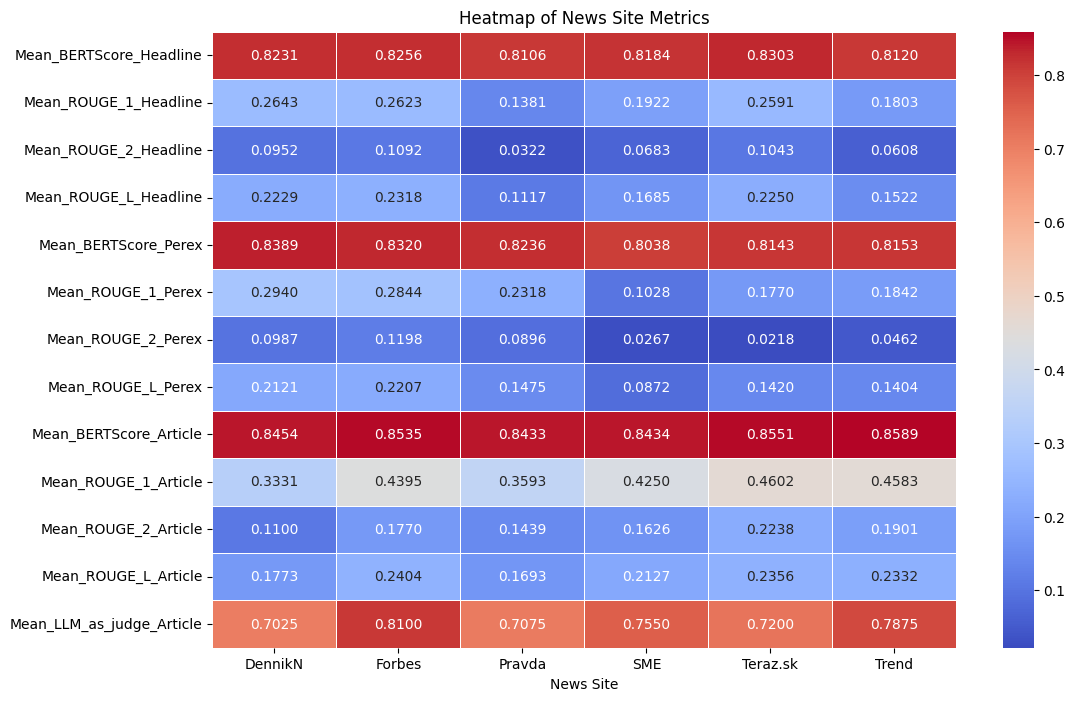

In [11]:
news_site_results_transposed = news_site_results.set_index('News Site').T

plt.figure(figsize=(12, 8))
sns.heatmap(news_site_results_transposed, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
plt.title('Heatmap of News Site Metrics')
plt.show()